# Prae-1b transit modelling with tight logg prior

Prae-1 transit modelling assuming a Normal prior on logg with $\mu=4.81$, and $\sigma=0.08$.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm
%run ../src/core.py
mcfile = join(DRESULT, '02c.npz')

## Run DE and MCMC

The Differential Evolution optimization takes $\sim$30 seconds, and the MCMC sampling $\sim$25 minutes. Comment out the `do_mcmc = False` line to run the MCMC sampling.

In [3]:
npop, de_iter, mc_iter = 100, 200, 40000
thin, burn = 100, 50
lpf = LPFunction(logg_prior = NP(4.81, 0.08, 'logg', lims=(1,10)))
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

In [4]:
do_mcmc = True
do_mcmc = False

if do_mcmc:
    for r in tqdm(de(de_iter), total=de_iter): pass

    for i,r in enumerate(tqdm(sampler.sample(de.population, iterations=mc_iter, thin=thin), total=mc_iter)):
        if ((i > 0) and (i%500 == 0)) or (i == mc_iter-1):
            savez(mcfile, chains=sampler.chain)
            
chain = load(mcfile)['chains']
fc = chain[:,burn:,:].reshape([-1,lpf.ps.ndim])
mp = median(fc, 0)

## Create the dataframe

In [5]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['tcc'] = df.tc - floor(df.tc.mean())
df['pc'] = df.p - 10
df['ecc'] = df.secw**2+df.sesw**2
df['w'] = arctan2(df.sesw, df.secw)
df['e'] *= 1e6
df['k'] = sqrt(df.k2)
df['a'] = as_from_rhop(df.rho, df.p)
df['I'] = i_from_baew(*df['b a ecc w'.split()].values.T)
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df['T14'] = [of.duration_eccentric_f(p,k,a,i,e,w,1) for _,(p,k,a,i,e,w) in df['p k a I ecc w'.split()].iterrows()]
df = df.drop(['k2','q1','q2'], axis=1)

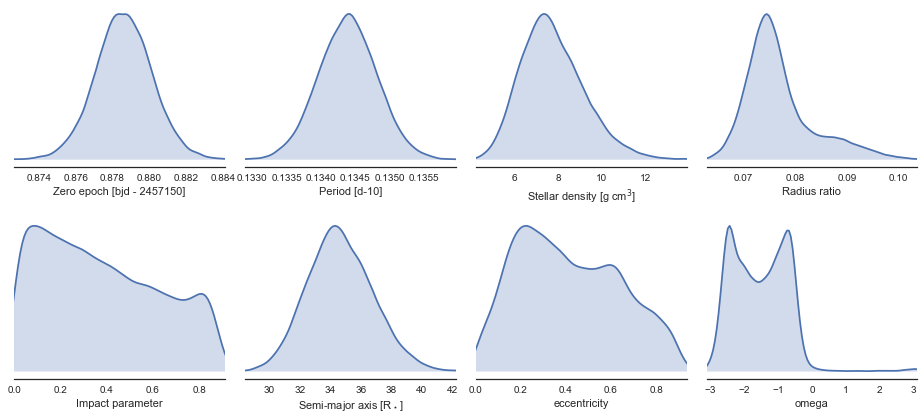

In [6]:
fig,ax = subplots(2, 4, figsize=(13,6))

pars = 'tcc pc rho k b a ecc w'.split()
labels = ('Zero epoch [bjd - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$], eccentricity, omega'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    sb.kdeplot(df[par], ax=ax.flat[i], legend=False, shade=True)
    setp(ax.flat[i], xlabel=label, xlim=percentile(df[par], [0.05,99.95]), yticks=[])

sb.despine(fig, left=True)
fig.tight_layout()
fig.savefig(join(DPLOT, 'basic_parameter_estimates_wn_loose.pdf'))

## Plot the light curve

In [7]:
pvs = permutation(fc)[:100]
time_m = linspace(mp[0]-0.03*mp[1], mp[0]+0.03*mp[1], 1500)
mphase_o_d = 24*mp[1]*(fold(lpf.time, mp[1], mp[0], 0.5, normalize=True) - 0.5)
mphase_m_d = 24*mp[1]*(fold(time_m,   mp[1], mp[0], 0.5, normalize=True) - 0.5)

flux_pr = array([lpf.compute_lc_model(pv, time_m) for pv in pvs])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
flux_mo = median(array([lpf.compute_lc_model(pv, time_m) for pv in pvs]), 0)

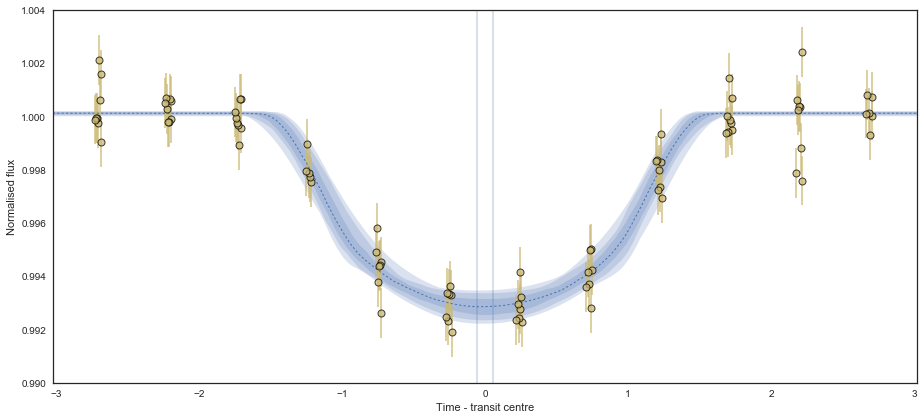

In [8]:
with sb.axes_style('white'):
    fig, ax = subplots(1,1, figsize=(13,6))
    hT14 = 0.5*median(df.T14)
    cp = sb.color_palette()
    sids = argsort(mphase_m_d)
    ax.errorbar(mphase_o_d, lpf.flux, mp[9], fmt='o', c=cp[4], alpha=0.75, markeredgecolor='k', markeredgewidth=1)
    [ax.fill_between(mphase_m_d[sids],*flux_pc[i:i+2,sids],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(mphase_m_d[sids], flux_pc[0,sids], c=cp[0], lw=1, ls=':')
    [ax.axvline(c*hT14, alpha=0.25) for c in [-1,1]]
    setp(ax, xlim=(-3.02,3.02), ylim=(0.99,1.004),xlabel='Time - transit centre', ylabel='Normalised flux')
    fig.tight_layout()
    fig.savefig(join(DPLOT, 'lc_model_wn_tight.pdf'))

---

<center> &copy; 2017 Hannu Parviainen</center>